# Emittance Sample study


# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.analysis import compute_emit_bmag
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import GridMinimizeEmitBmag

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
if torch.cuda.is_available():
# if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    tkwargs = {"dtype": torch.double, "device": "cuda"}
    use_cuda = True
    print('Using cuda.')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

In [3]:
torch.cuda.is_available()

False

# Notebook settings

In [4]:
ndim = 5 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thick_quad = True
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 25 #number of random initial observations for GP model
n_samples = 3 #number of posterior samples for BAX
n_iter = 1 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 3

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)
print(rmat_x)
print(rmat_y)

tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])
tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])


In [6]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

from emitopt.utils import get_quad_scale_factor
scale_factor = get_quad_scale_factor(E=.08, q_len=q_len)

def measure_beamsize(input_dict):
    scale = 1.e3
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key != str(meas_param):
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + 1*x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': (float(xrms)*scale)**2.+50,
            'yrms_sq': (float(yrms)*scale)**2.+50} # mean-square beam sizes in mm squared

# Construct vocs

In [7]:
variables = {var_name: [-2,1] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1', 'x2', 'x3', 'x4']
meas_param = 'x1'
domain =
 [[-2.  1.]
 [-3.  3.]
 [-2.  1.]
 [-2.  1.]
 [-2.  1.]]


In [8]:
def eval_true_emittance(x, use_bmag=False):
    emits = []
    bmags = []
    q = torch.linspace(-3,3,11)
    k = scale_factor*q
    ks = torch.stack((k,-k))
    rmats = torch.stack((rmat_x, rmat_y))
    for setting in x:
        bssx = []
        bssy = []
        input_dict = {name: float(setting[i]) for i, name in enumerate(vocs.variable_names)}
        for v in q.numpy():
            input_dict[meas_param] = v
            output_dict = measure_beamsize(input_dict)
            bssx += [output_dict['xrms_sq']]
            bssy += [output_dict['yrms_sq']]
        bss = torch.tensor([bssx, bssy])
        beta0 = torch.tensor([[10], [11]])
        alpha0 = torch.tensor([[-1], [-2]])
        emit, bmag, sig, is_valid = compute_emit_bmag(ks, bss, q_len, rmats, beta0=beta0, alpha0=alpha0, thick=True)
        emits += [torch.sqrt(emit[0]*emit[1])]
        bmags += [torch.sqrt(bmag[0].min()*bmag[1].min())]
    res = torch.tensor(emits)
    if use_bmag:
        res *= torch.tensor(bmags)
    return res
eval_true_emittance(torch.zeros(1,ndim), use_bmag=False)

tensor([1.0367])

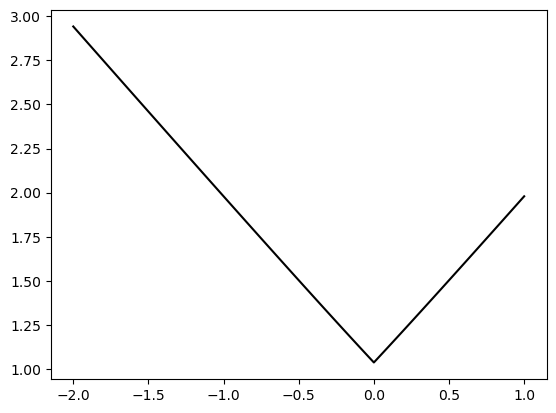

In [9]:
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
plt.plot(x[:,0], eval_true_emittance(x, use_bmag=False), c='k')

# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [10]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittanceXY

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [11]:
from xopt.numerical_optimizer import LBFGSOptimizer, GridOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_restarts=20,
                                    max_time=2)
# numerical_optimizer = GridOptimizer()

# Construct generator, evaluator, Xopt objects

In [12]:
from bax_algorithms.emittance import PathwiseMinimizeEmittance
from bax_algorithms.pathwise.optimize import DifferentialEvolution

#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'twiss0_x': torch.tensor([10., -1.]),
        'twiss0_y': torch.tensor([11., -2.]),
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 3,
        'use_bmag': False,
        'observable_names_ordered': ['xrms_sq','yrms_sq'],
        'optimizer': DifferentialEvolution(minimize=True, maxiter=20, verbose=True),
        # 'maxiter_fit': 10,
}
algo = PathwiseMinimizeEmittance(**algo_kwargs)
# algo = GridMinimizeEmitBmag(**algo_kwargs)
# algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

generator.gp_constructor.use_low_noise_prior = True
#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [13]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,x2,x3,x4,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-0.652394,-1.681889,0.383769,0.799092,0.423783,54.932645,50.061735,0.000498,False
1,-1.124443,1.161819,0.395864,0.782314,-1.177009,50.145944,66.749167,0.000280,False
2,0.127286,1.668253,-0.542105,0.403072,-1.354810,50.059894,63.685099,0.000270,False
3,-0.532483,0.672172,0.738312,0.544417,-1.916295,50.701698,62.751445,0.000546,False
4,-1.678841,-2.618302,-0.450757,0.699687,-1.552914,72.918622,52.621517,0.000265,False
5,-1.688879,-2.855973,-0.086529,0.612118,-0.630783,64.351672,52.235922,0.000260,False
6,0.623244,-1.034302,-1.123060,-0.659833,0.730627,54.982412,50.811340,0.000259,False
7,0.378271,-2.417005,-1.240239,0.436556,-0.466620,58.844913,50.721209,0.000503,False
8,0.845598,-2.074505,-1.073279,-1.856304,-1.783809,75.393820,50.895083,0.000934,False
9,-0.322430,0.732036,-1.067541,-1.044835,-1.362855,50.626659,63.791308,0.000528,False


Sample optimization took: 1.6086370944976807 seconds.
Sample optimization took: 1.6214087009429932 seconds.


(<Figure size 600x400 with 2 Axes>,
 array([[<Axes: ylabel='xrms_sq'>],
        [<Axes: xlabel='x1', ylabel='yrms_sq'>]], dtype=object))

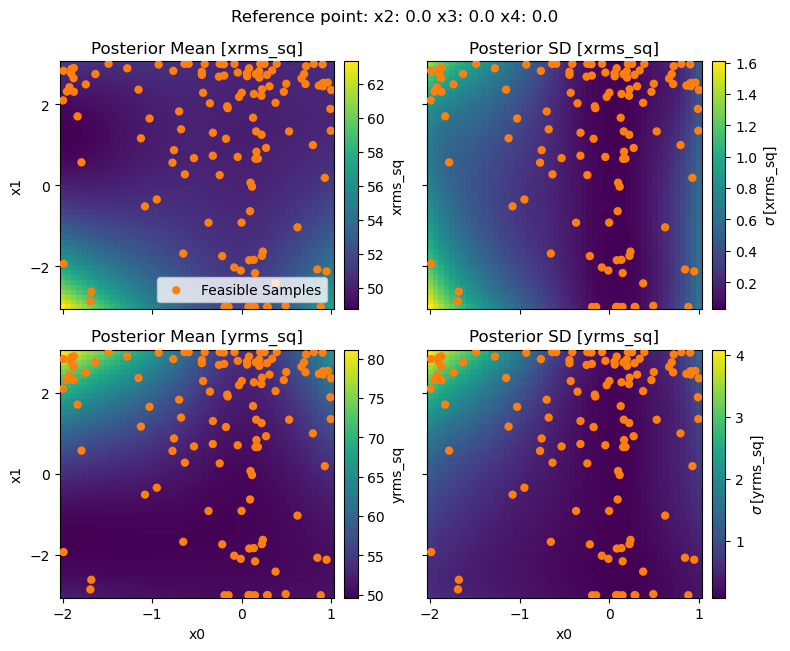

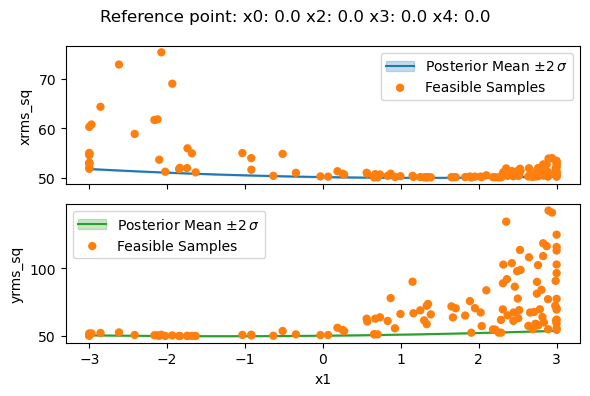

In [18]:
from xopt.generators.bayesian.visualize import visualize_generator_model
optimizer.generator.train_model()
visualize_generator_model(optimizer.generator, 
                          variable_names=['x0','x1'], 
                            reference_point={'x0':0.,
                                             'x1':0.,
                                            'x2':0.,
                                             'x3':0.,
                                             'x4':0.,
                                             'x5':0.,
                                             'x6':0.,
                                             'x7':0.,
                                             'x8':0.,
                                            },
                          show_acquisition=False)
visualize_generator_model(optimizer.generator, 
                          variable_names=['x1'], 
                            reference_point={'x0':0.,
                                             'x1':0.,
                                            'x2':0.,
                                             'x3':0.,
                                             'x4':0.,
                                             'x5':0.,
                                             'x6':0.,
                                             'x7':0.,
                                             'x8':0.,
                                            },
                          show_acquisition=False)

In [19]:
optimizer.generator.algorithm.results['best_x']

tensor([[[-0.0657,  0.2475,  0.1839, -1.0699]],

        [[ 0.2333,  0.3432,  0.6879, -1.1673]],

        [[-0.0136, -0.1128, -0.4045, -0.0311]]])

In [16]:
for i in range(100):
    print(i)
    start = time.time()
    optimizer.step()
    print(time.time() - start)

0
Sample optimization took: 1.8991303443908691 seconds.
4.509857416152954
1
Sample optimization took: 1.6647899150848389 seconds.
5.155371427536011
2
Sample optimization took: 1.9106619358062744 seconds.
5.483635902404785
3
Sample optimization took: 1.8243820667266846 seconds.
5.656529903411865
4
Sample optimization took: 1.810833215713501 seconds.
5.310628175735474
5
Sample optimization took: 1.6624650955200195 seconds.
6.060736894607544
6
Sample optimization took: 1.8481886386871338 seconds.
5.792231321334839
7
Sample optimization took: 1.4697773456573486 seconds.
5.281496047973633
8
Sample optimization took: 1.2290053367614746 seconds.
5.526040077209473
9
Sample optimization took: 1.7687811851501465 seconds.
5.060438632965088
10
Sample optimization took: 1.7555193901062012 seconds.
4.649274110794067
11
Sample optimization took: 1.797255516052246 seconds.
5.627099990844727
12
Sample optimization took: 1.7682743072509766 seconds.
5.393688678741455
13
Sample optimization took: 1.639934

In [17]:
from xopt.generators.bayesian.bax.visualize import visualize_virtual_objective
model = optimizer.generator.train_model()

# for i in range(10):
start = time.time()
fig, ax = visualize_virtual_objective(optimizer.generator, 
                            variable_names=['x0'],
                            reference_point={'x0':torch.tensor([0.]),
                                             'x1':torch.tensor([0.]),
                                            'x2':torch.tensor([0.]),
                                             'x3':torch.tensor([0.]),
                                             'x4':torch.tensor([0.]),
                                             # 'x5':torch.tensor([0.]),
                                             # 'x6':torch.tensor([0.]),
                                             # 'x7':torch.tensor([0.]),
                                             # 'x8':torch.tensor([0.]),
                                            },
                            n_grid=100,
                            n_samples=100,
                            # show_samples=True,
                                     )
print(time.time()-start)
x = torch.zeros(100, ndim)
x[:,0] = torch.linspace(*vocs.bounds.T[0], 100)
plt.plot(x[:,0], eval_true_emittance(x, use_bmag=False), c='k')
# plt.ylim(top=0.01)

TypeError: torch.Size() takes an iterable of 'int' (item 0 is 'NoneType')

In [ ]:
bmag = algo.results['bmag']
bmag_mean = (bmag[...,0] * bmag[...,1]).sqrt()
bmag_min, bmag_min_id = torch.min(bmag_mean, dim=-1)
plt.plot(x[:,:,0].T,bmag_min.flatten())

In [ ]:
bmag.shape

In [ ]:
sample_funcs_list = []
for cpu_model in cpu_models:
    sample_funcs = draw_product_kernel_post_paths(cpu_model, n_samples=10)
    sample_funcs_list += [sample_funcs]

from emitopt.algorithms import unif_random_sample_domain
x0 = unif_random_sample_domain(1000, vocs.bounds.T)
start = time.time()
algo.evaluate_virtual_objective(sample_funcs_list, x0.reshape(10, 100, -1), bounds)
print(time.time()-start)

In [ ]:
# from emitopt.utils import x_tuning_to_dict, get_bax_optimum
# print(optimizer.generator.algorithm_results['x_tuning_best'])
# x_tuning_best = optimizer.generator.algorithm_results['x_tuning_best'].mean(dim=0)
# print(x_tuning_best)
# reference_point = get_bax_optimum(optimizer.generator)
# print(reference_point)
# target_point = x_tuning_to_dict(optimizer.generator, x_tuning = torch.tensor([[0]]))
# print(target_point)

In [ ]:
from emitopt.visualize import plot_virtual_measurement_scan
fig, ax, best_q = plot_virtual_measurement_scan(optimizer, reference_point, n_samples=10)
ax[0].set_ylim(top=1)
ax[1].set_ylim(top=3, bottom=0.9)
ax[0].axhline(0, c='k')

In [ ]:
import botorch
botorch.__version__